# Downloading the libaries

In [1]:
#importing libaries
import numpy as np 
import pandas as pd
import random as rd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
#setting seed for reproducability
from numpy.random import seed
seed(25)
tf.random.set_seed(50)

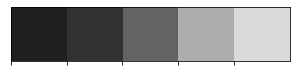

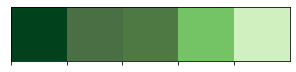

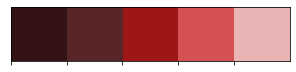

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

# Downloading the images

In [3]:
# 0 - Normal
# 1 - Tumor

data = [] #creating a list for images
paths = [] #creating a list for paths
labels = [] #creating a list to put our 0 or 1 labels

#staring with the images that have tumors
for r, d, f in os.walk(r'/home/sysadm/Documents/aritra/Ml/archive/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(1)

#now working with the images with no tumors        
paths = []
for r, d, f in os.walk(r"/home/sysadm/Documents/aritra/Ml/archive/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(0)
        
data = np.array(data)
data.shape

labels = np.array(labels)
labels = labels.reshape(2891,1)

print('data shape is:', data.shape)
print('labels shape is:', labels.shape)

data shape is: (2891, 128, 128, 3)
labels shape is: (2891, 1)


# Processing the images

In [4]:
#we have 2891 images with 128 height, 128 weight, RGB color channel
print(data.shape)

(2891, 128, 128, 3)


### Changing pixel values

Each pixel has a value between 255 and 0. We will reduce this down to 1 and 0 in order to help the neural network converge quicker.

In [5]:
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

255
0


In [6]:
#reducing the data to between 1 and 0
data = data / 255.00
#getting the max of the array
print(np.max(data))
#getting the min of the array
print(np.min(data))

1.0
0.0


### Visualizing the images

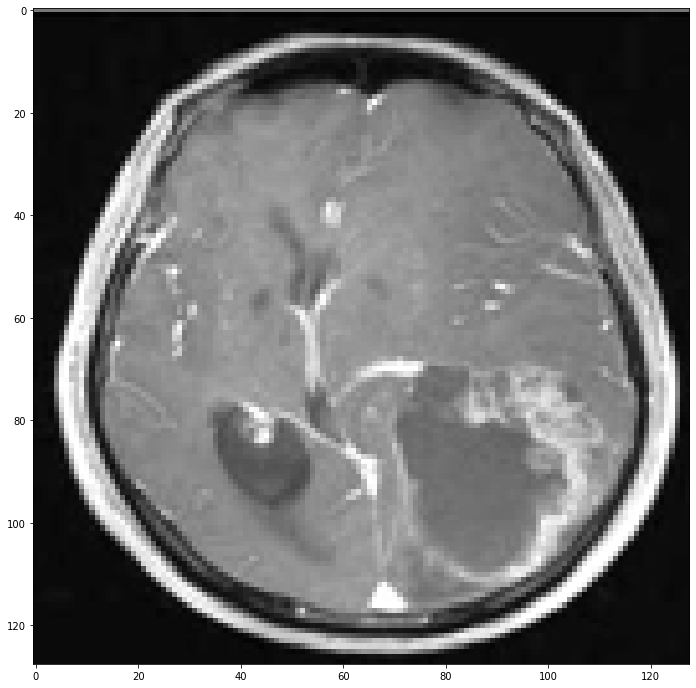

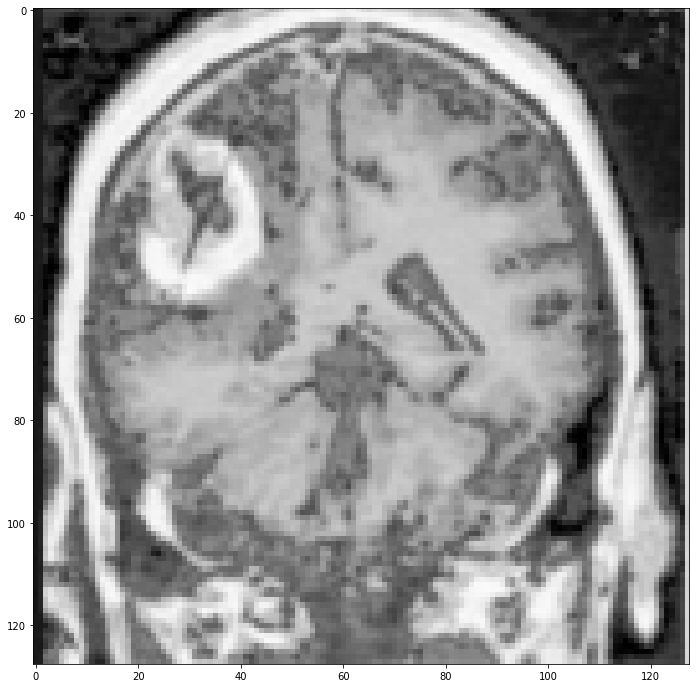

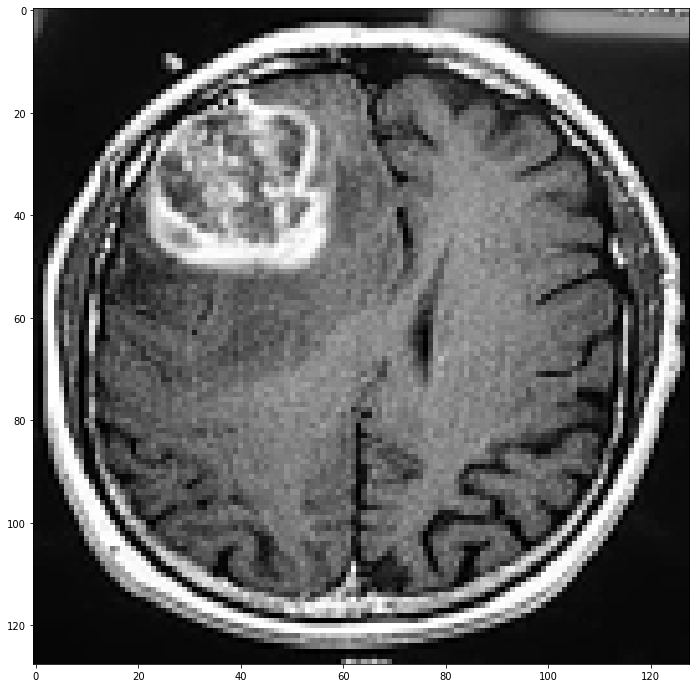

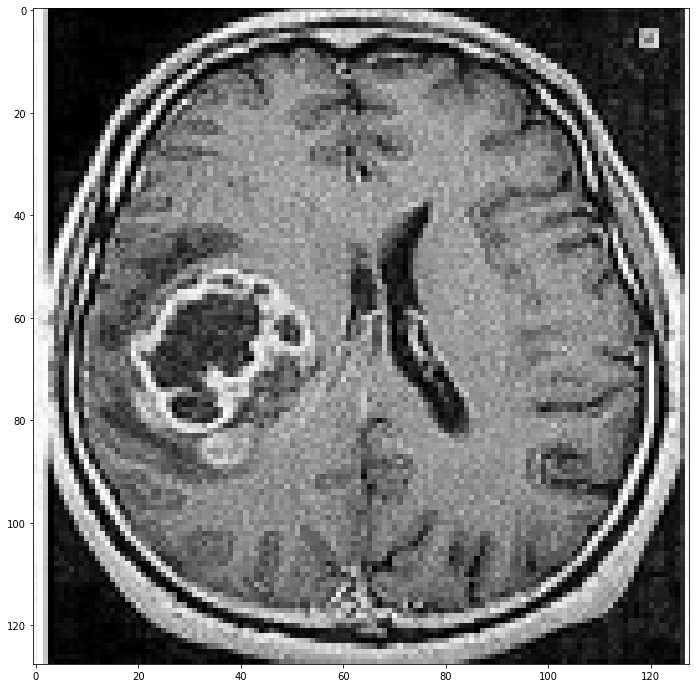

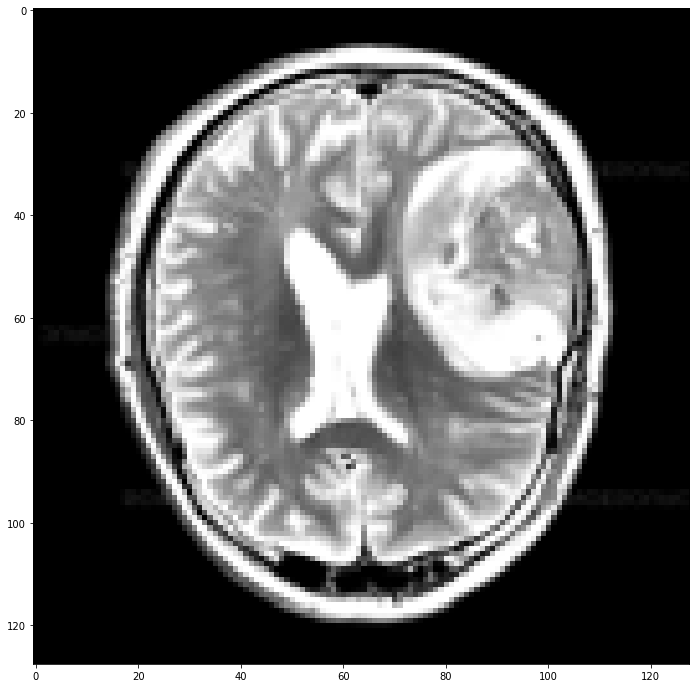

In [80]:
for i in range(5):
    fig = plt.figure(figsize=(70,70))
    plt.subplot(5,5,i+1)
    image = plt.imshow(data[i])
    plt.show(image)

# Model

### Creating training and test sets

Before we create our model we will split up the data into traing sets and test sets with 70% going to training and 30% going to testing.

In [8]:
x_train1,x_test,y_train1,y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, random_state=7)

In [9]:
x_train,x_val,y_train,y_val = train_test_split(x_train1, y_train1, test_size=0.1, shuffle=True, random_state=7)

In [10]:
print("shape of our training data:",x_train.shape)
print("shape of our training labels:",y_train.shape)
print("shape of our validation data:",x_val.shape)
print("shape of our validation labels:",y_val.shape)
print("shape of our test data:",x_test.shape)
print("shape of our test labels:",y_test.shape)

shape of our training data: (2080, 128, 128, 3)
shape of our training labels: (2080, 1)
shape of our validation data: (232, 128, 128, 3)
shape of our validation labels: (232, 1)
shape of our test data: (579, 128, 128, 3)
shape of our test labels: (579, 1)


## 1 Creating CNN baseline model (without augmentation)

We will start with creating a sequential model set up for binary classification using the keras libary.

In [11]:
model_b = keras.Sequential([
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

model_b.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [12]:
model_b.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [13]:
history_1 = model_b.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_val,y_val),
    batch_size = 64,
    epochs=20,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/20
33/33 - 24s - loss: 0.6854 - accuracy: 0.5644 - val_loss: 0.6682 - val_accuracy: 0.7500 - 24s/epoch - 742ms/step
Epoch 2/20
33/33 - 24s - loss: 0.6536 - accuracy: 0.7024 - val_loss: 0.6148 - val_accuracy: 0.7457 - 24s/epoch - 715ms/step
Epoch 3/20
33/33 - 24s - loss: 0.5810 - accuracy: 0.7144 - val_loss: 0.5733 - val_accuracy: 0.7284 - 24s/epoch - 713ms/step
Epoch 4/20
33/33 - 24s - loss: 0.5486 - accuracy: 0.7236 - val_loss: 0.5417 - val_accuracy: 0.7241 - 24s/epoch - 713ms/step
Epoch 5/20
33/33 - 24s - loss: 0.5355 - accuracy: 0.7298 - val_loss: 0.5581 - val_accuracy: 0.7026 - 24s/epoch - 713ms/step
Epoch 6/20
33/33 - 24s - loss: 0.5235 - accuracy: 0.7385 - val_loss: 0.5157 - val_accuracy: 0.7414 - 24s/epoch - 713ms/step
Epoch 7/20
33/33 - 24s - loss: 0.5028 - accuracy: 0.7534 - val_loss: 0.4834 - val_accuracy: 0.7672 - 24s/epoch - 717ms/step
Epoch 8/20
33/33 - 24s - loss: 0.4794 - accuracy: 0.7692 - val_loss: 0.4807 - val_accuracy: 0.7759 - 24s/epoch - 718ms/step
Epoch 9/

### Plotting the Losses and Accuracies

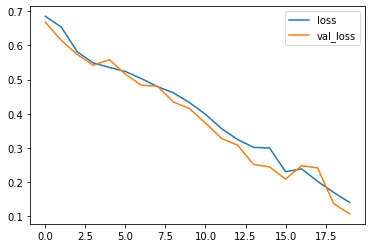

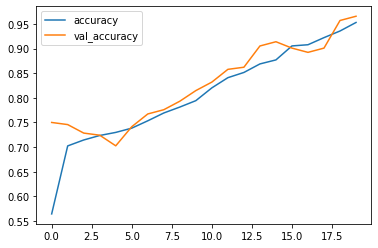

In [14]:
history_frame = pd.DataFrame(history_1.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

### Evaluating the Model on Test Data

In [15]:
scores = model_b.evaluate(x_test,y_test)
print("%s%s: %.2f%%" % ("evaluate ",model_b.metrics_names[1], scores[1]*100))

19/19 [==============================] - 1s 67ms/step - loss: 0.1575 - accuracy: 0.9482
evaluate accuracy: 94.82%


### Prediction

In [16]:
pred_b = model_b.predict(x_test)

for i in range(len(pred_b)):
    if pred_b[i] > 0.5:
        pred_b[i] = 1
    else:
        pred_b[i] = 0
pred_b = pred_b.astype(int)

### Confusion Matrix

In [17]:
labels = ["No tumor","Yes"]

In [19]:
y_test=y_test.reshape(579,)
pred_b=pred_b.reshape(579,)

In [20]:
b = pd.crosstab(y_test,pred_b);b

col_0,0,1
row_0,,
0,263,22
1,8,286


### Classification Report

In [21]:
#creating a classification report
print(classification_report(y_test, pred_b))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       285
           1       0.93      0.97      0.95       294

    accuracy                           0.95       579
   macro avg       0.95      0.95      0.95       579
weighted avg       0.95      0.95      0.95       579



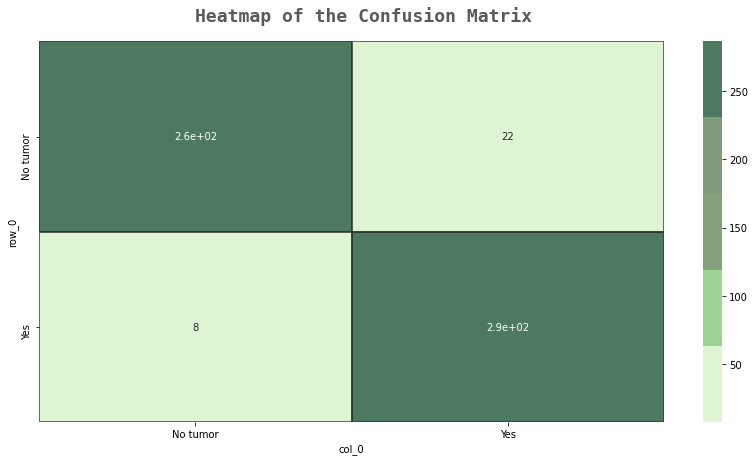

In [22]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(b,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[1])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## 2. Creating CNN baseline model (with Augmentation)

In [23]:
model_b_a = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.5),
    
    layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[128, 128, 3]),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [24]:
model_b_a.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=30,
    min_delta=0.001,
    restore_best_weights=True,
)

In [25]:
history2 = model_b_a.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_val,y_val),
    batch_size = 64,
    epochs=20,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/20
33/33 - 26s - loss: 0.6757 - accuracy: 0.6005 - val_loss: 0.6512 - val_accuracy: 0.7112 - 26s/epoch - 776ms/step
Epoch 2/20
33/33 - 24s - loss: 0.6277 - accuracy: 0.6784 - val_loss: 0.6321 - val_accuracy: 0.6509 - 24s/epoch - 738ms/step
Epoch 3/20
33/33 - 24s - loss: 0.6048 - accuracy: 0.6899 - val_loss: 0.5907 - val_accuracy: 0.7198 - 24s/epoch - 732ms/step
Epoch 4/20
33/33 - 24s - loss: 0.5864 - accuracy: 0.7188 - val_loss: 0.5729 - val_accuracy: 0.7371 - 24s/epoch - 733ms/step
Epoch 5/20
33/33 - 24s - loss: 0.5780 - accuracy: 0.7188 - val_loss: 0.5782 - val_accuracy: 0.7198 - 24s/epoch - 731ms/step
Epoch 6/20
33/33 - 24s - loss: 0.5613 - accuracy: 0.7274 - val_loss: 0.5498 - val_accuracy: 0.7543 - 24s/epoch - 734ms/step
Epoch 7/20
33/33 - 24s - loss: 0.5545 - accuracy: 0.7250 - val_loss: 0.5429 - val_accuracy: 0.7543 - 24s/epoch - 735ms/step
Epoch 8/20
33/33 - 24s - loss: 0.5398 - accuracy: 0.7486 - val_loss: 0.5558 - val_accuracy: 0.7759 - 24s/epoch - 737ms/step
Epoch 9/

In [26]:
model_b_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)      

### Plotting the Losses and Accuracies

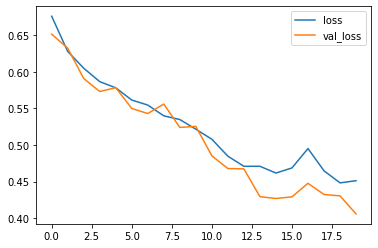

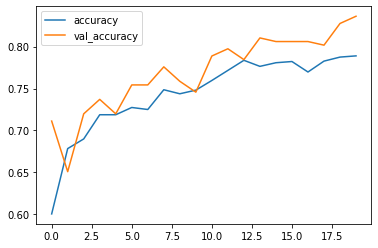

In [27]:
history_frame = pd.DataFrame(history2.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

### Evaluating the model on Test data

In [28]:
scores = model_b_a.evaluate(x_test,y_test)
print("%s%s: %.2f%%" % ("evaluate ",model_b_a.metrics_names[1], scores[1]*100))

19/19 [==============================] - 1s 67ms/step - loss: 0.4134 - accuracy: 0.8152
evaluate accuracy: 81.52%


### Prediction

In [29]:
pred_b_a = model_b_a.predict(x_test)

for i in range(len(pred_b_a)):
    if pred_b_a[i] > 0.5:
        pred_b_a[i] = 1
    else:
        pred_b_a[i] = 0

pred_b_a = pred_b_a.astype(int)

In [30]:
y_test=y_test.reshape(579,)
pred_b_a=pred_b_a.reshape(579,)

### Confusion Matrix

In [32]:
labels = ["No tumor","Yes"]

In [33]:
c = pd.crosstab(y_test,pred_b_a);c

col_0,0,1
row_0,,
0,217,68
1,39,255


### Classification Report 

In [34]:
#creating a classification report
print(classification_report(y_test, pred_b_a))

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       285
           1       0.79      0.87      0.83       294

    accuracy                           0.82       579
   macro avg       0.82      0.81      0.81       579
weighted avg       0.82      0.82      0.81       579



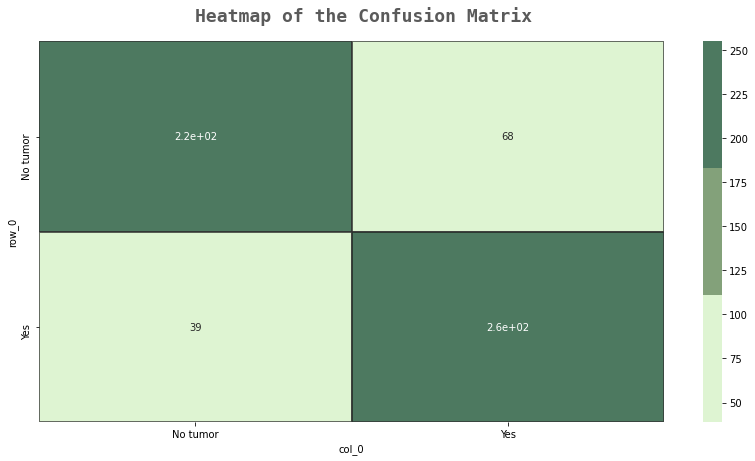

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(c,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-2],alpha=0.7,linewidths=2,linecolor=colors_dark[1])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## Pretrained models

## VGG16

In [36]:
# load base model
base_model = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=(128,128,3)
)

In [38]:
model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomRotation(0.5),
    base_model, #vgg16
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.001,
    restore_best_weights=True,
)

In [40]:
history = model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_val,y_val),
    batch_size = 64,
    epochs=20,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/20
33/33 - 250s - loss: 0.5661 - accuracy: 0.7024 - val_loss: 0.4361 - val_accuracy: 0.8578 - 250s/epoch - 8s/step
Epoch 2/20
33/33 - 249s - loss: 0.3469 - accuracy: 0.8510 - val_loss: 0.2169 - val_accuracy: 0.9138 - 249s/epoch - 8s/step
Epoch 3/20
33/33 - 249s - loss: 0.1695 - accuracy: 0.9404 - val_loss: 0.1507 - val_accuracy: 0.9353 - 249s/epoch - 8s/step
Epoch 4/20
33/33 - 248s - loss: 0.1129 - accuracy: 0.9615 - val_loss: 0.1664 - val_accuracy: 0.9397 - 248s/epoch - 8s/step
Epoch 5/20
33/33 - 248s - loss: 0.0992 - accuracy: 0.9668 - val_loss: 0.0655 - val_accuracy: 0.9741 - 248s/epoch - 8s/step
Epoch 6/20
33/33 - 248s - loss: 0.0516 - accuracy: 0.9817 - val_loss: 0.4933 - val_accuracy: 0.8578 - 248s/epoch - 8s/step
Epoch 7/20
33/33 - 248s - loss: 0.0724 - accuracy: 0.9697 - val_loss: 0.0468 - val_accuracy: 0.9828 - 248s/epoch - 8s/step
Epoch 8/20
33/33 - 248s - loss: 0.0635 - accuracy: 0.9793 - val_loss: 0.0474 - val_accuracy: 0.9871 - 248s/epoch - 8s/step
Epoch 9/20
33/33

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                      

### Plotting the Losses and Accuracies

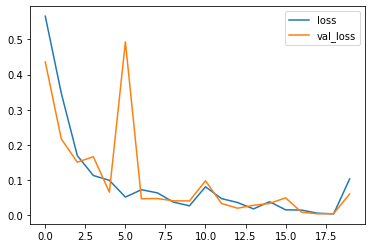

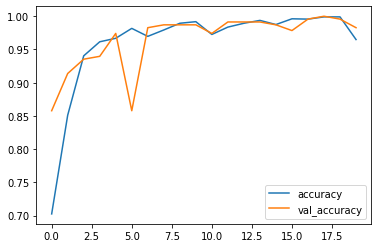

In [42]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

### Prediction

In [43]:
pred = model.predict(x_test)

for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0

pred = pred.astype(int)

### Evaluating the Model on Test Data

In [44]:
scores = model.evaluate(x_test,y_test)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

19/19 [==============================] - 15s 764ms/step - loss: 0.0780 - accuracy: 0.9706
evaluate accuracy: 97.06%


### Classification Report

In [45]:
#creating a classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       285
           1       0.95      0.99      0.97       294

    accuracy                           0.97       579
   macro avg       0.97      0.97      0.97       579
weighted avg       0.97      0.97      0.97       579



### Confusion Matrix

In [46]:
y_test_v=y_test.reshape(579,)
pred_v=pred.reshape(579,)

In [47]:
a = pd.crosstab(y_test_v,pred_v)
a

col_0,0,1
row_0,,
0,271,14
1,3,291


In [48]:
labels = ["No tumor","Yes"]

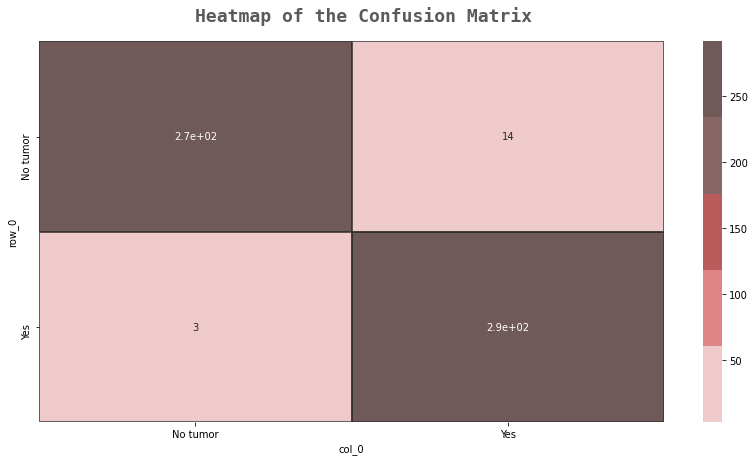

In [49]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(a,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_red[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[1])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

## Resnet50

In [50]:
# load base model
base_model_1 = ResNet50(
    weights="imagenet",
    include_top=False, 
    input_shape=(128,128,3)
)

In [63]:
model_r = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomRotation(0.5),
    base_model_1, 
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [64]:
model_r.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.001,
    restore_best_weights=True,
)

In [65]:
history3 = model_r.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_val,y_val),
    batch_size = 64,
    epochs=20,
    callbacks=[early_stopping],
    verbose=(2),
)

Epoch 1/20
33/33 - 126s - loss: 0.0781 - accuracy: 0.9683 - val_loss: 2.1080 - val_accuracy: 0.6379 - 126s/epoch - 4s/step
Epoch 2/20
33/33 - 119s - loss: 0.0058 - accuracy: 0.9981 - val_loss: 1.8097 - val_accuracy: 0.6940 - 119s/epoch - 4s/step
Epoch 3/20
33/33 - 118s - loss: 0.0107 - accuracy: 0.9976 - val_loss: 2.5288 - val_accuracy: 0.6509 - 118s/epoch - 4s/step
Epoch 4/20
33/33 - 118s - loss: 0.0048 - accuracy: 0.9981 - val_loss: 1.1979 - val_accuracy: 0.7931 - 118s/epoch - 4s/step
Epoch 5/20
33/33 - 118s - loss: 0.0052 - accuracy: 0.9976 - val_loss: 0.6374 - val_accuracy: 0.8793 - 118s/epoch - 4s/step
Epoch 6/20
33/33 - 118s - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.5353 - val_accuracy: 0.8707 - 118s/epoch - 4s/step
Epoch 7/20
33/33 - 118s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.6361 - val_accuracy: 0.8750 - 118s/epoch - 4s/step
Epoch 8/20
33/33 - 119s - loss: 0.0375 - accuracy: 0.9918 - val_loss: 0.4621 - val_accuracy: 0.8836 - 119s/epoch - 4s/step
Epoch 9/20
33/33

In [66]:
model_r.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_4 (Dropout)         (None, 32768)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               8388864   
                                                      

### Plotting the Losses and Accuracies

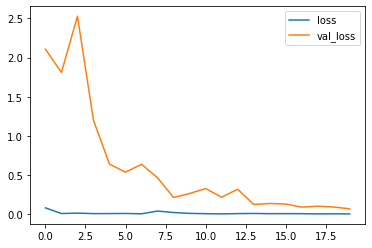

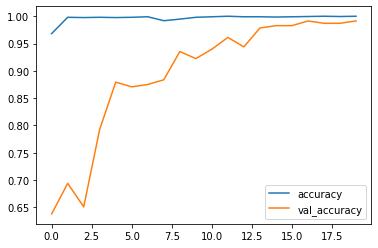

In [67]:
history_frame = pd.DataFrame(history3.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();

### Prediction

In [68]:
pred_r = model_r.predict(x_test)

for i in range(len(pred_r)):
    if pred_r[i] > 0.5:
        pred_r[i] = 1
    else:
        pred_r[i] = 0

pred_r = pred_r.astype(int)

### Evaluation on Test Set

In [69]:
scores_r = model_r.evaluate(x_test,y_test)
print("%s%s: %.2f%%" % ("evaluate ",model_r.metrics_names[1], scores_r[1]*100))

19/19 [==============================] - 8s 371ms/step - loss: 0.0235 - accuracy: 0.9948
evaluate accuracy: 99.48%


### Classification Report

In [70]:
#creating a classification report
print(classification_report(y_test, pred_r))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       285
           1       0.99      1.00      0.99       294

    accuracy                           0.99       579
   macro avg       0.99      0.99      0.99       579
weighted avg       0.99      0.99      0.99       579



### Confusion Matrix

In [71]:
y_test_r=y_test.reshape(579,)
pred_r=pred_r.reshape(579,)

In [72]:
d = pd.crosstab(y_test_r,pred_r)
d

col_0,0,1
row_0,,
0,282,3
1,0,294


In [73]:
labels = ["No tumor","Yes"]

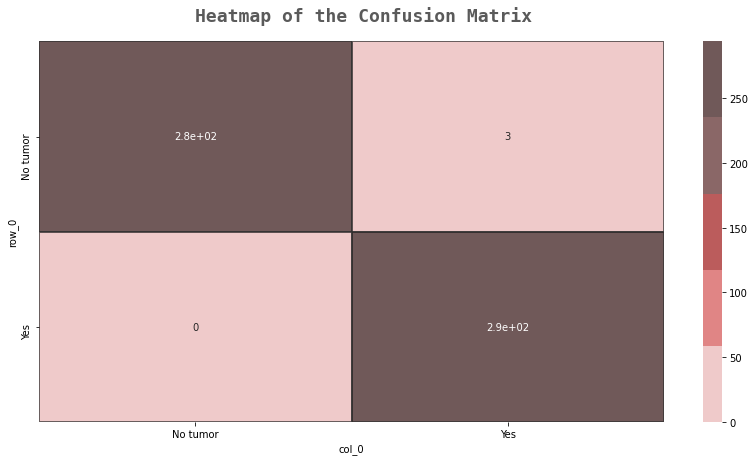

In [74]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(d,ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_red[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[1])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()